# 2つのガウス分布を含む混合ガウス分布のためのEMアルゴリズム

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、2つの2次元ガウス分布を含む混合ガウス分布から生成されたデータについて、EMアルゴリズムでパラメータを求めるためのEMアルゴリズムの実装例です。

## アルゴリズムを適用される対象になるデータの生成

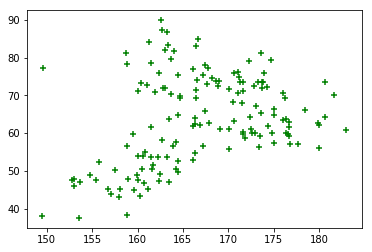

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# グループ1のガウス分布
mu1_ans = [170,70]
cov1_ans = [[6**2,-30],[-30,8**2]]
samples1 = np.random.multivariate_normal(mu1_ans,cov1_ans,100).T #サンプル生成

# グループ2のガウス分布
mu2_ans = [160,50]
cov2_ans = [[5.**2,20],[20,6**2]]
samples2 = np.random.multivariate_normal(mu2_ans,cov2_ans,50).T #サンプル生成

# 2つのグループを混ぜる
samples = np.column_stack((samples1,samples2))

# 描画
plt.scatter(samples[0],samples[1],color='g',marker='+')

## パラメータの初期設定

In [2]:
K = 2 #クラスタの数

mus = [[10*k,10*k] for k in range(K)] #分布の中心のリスト（初期位置をずらしておく）
covs = [[[100,0],[0,100]] for k in range(K)] #共分散のリスト
pi = [1.0/K for k in range(K)] #混合係数のリスト

## Eステップの実装

分布を固定し、各サンプルがどっちの分布に属すかを負担率という値で返します。

In [3]:
from scipy.stats import multivariate_normal

def expectation_step(X,K,mus,covs,pi):
    X_num = len(X[0]) # サンプルの数（X座標の数X[0]でカウント）
    
    # 2つのガウス分布のオブジェクトを作る（Eステップでは固定）
    distributions = [multivariate_normal(mean=mus[k], cov=covs[k]) for k in range(K)] 

    # 分布とサンプルを描画
    for k in range(K):
        x, y = np.mgrid[0:200:1, 0:200:1]
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x; pos[:, :, 1] = y
        plt.contour(x, y, distributions[k].pdf(pos))
    
    plt.scatter(X[0],X[1],color='g',marker='+')
        
    # 負担率の計算
    gamma = [] # 負担率のリスト
    for n in range(X_num):
        # サンプルの地点における各分布の値（密度）を計算
        ds = [ pi[k] * distributions[k].pdf([X[0][n],X[1][n]]) for k in range(K) ] 
        gamma.append([ds[k]/sum(ds) for k in range(K)])


    return gamma

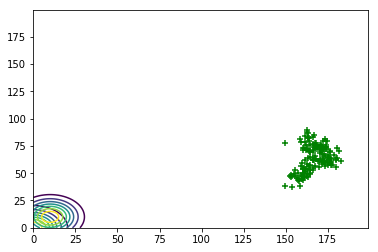

In [4]:
gamma = expectation_step(samples,K,mus,covs,pi)

## Mステップの実装

In [5]:
print(gamma)

[[9.9542269127334074e-11, 0.99999999990045785], [1.0179108170700188e-10, 0.99999999989820887], [6.4380213589837927e-11, 0.99999999993561983], [3.2245077559748183e-11, 0.9999999999677549], [2.1735729225212982e-10, 0.99999999978264276], [5.6273017492921431e-11, 0.9999999999437269], [1.0457551706897e-10, 0.99999999989542454], [1.7344012895107546e-10, 0.99999999982655985], [7.4290240486971365e-11, 0.99999999992570976], [1.7139992778510024e-10, 0.99999999982859999], [3.7975866964787567e-11, 0.99999999996202416], [7.8629415130700724e-11, 0.99999999992137067], [1.5135816349415712e-10, 0.99999999984864185], [5.730356383388245e-11, 0.99999999994269639], [7.0298235391367234e-11, 0.99999999992970168], [7.8441959062414437e-11, 0.99999999992155808], [9.5724745489001234e-11, 0.99999999990427524], [1.3450242090810041e-10, 0.99999999986549759], [5.8781837126944317e-11, 0.99999999994121813], [1.7648751601971132e-10, 0.9999999998235124], [1.8778271660107727e-10, 0.99999999981221721], [5.3474106678024564